# Classify snow-covered area (SCA) in Sentinel-2 imagery: full pipeline

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: where snow will be classified in all available images. 
- Google Earth Engine (GEE) account: used to pull DEM over the AOI. Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (DEM) (_optional_): used to extract elevations over the AOI and for each snowline. If no DEM is provided, the ASTER Global DEM will be loaded through GEE. 

### Outline:

0. Setup: Define paths in directory and desired settings

1. Sentinel-2 surface reflectance (SR) and top of atmosphere (TOA) imagery

2. Landsat 8/9 surface reflectance (SR) imagery

3. PlanetScope surface reflectance imagery

---

### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [31]:
##### MODIFY HERE #####

# -----Paths in directory
site_name = 'SouthCascade'
# path to snow-cover-mapping/
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to AOI including the name of the shapefile
AOI_fn = base_path + '../study-sites/' + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
# path to DEM including the name of the tif file
# Note: set DEM_fn=None if you want to use the ASTER GDEM on Google Earth Engine
DEM_fn = base_path + '../study-sites/' + site_name + '/DEMs/' + site_name + '*_DEM*.tif'
# path for output images
out_path = base_path + '../study-sites/' + site_name + '/imagery/'
# path for output figures
figures_out_path = base_path + '../study-sites/' + site_name + '/figures2/'

# -----Define image search filters
date_start = '2015-05-01'
date_end = '2017-12-01'
month_start = 5
month_end = 10
cloud_cover_max = 100

# -----Determine settings
plot_results = True # = True to plot figures of results for each image where applicable
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max blue SR < 0.8
crop_to_AOI = True # = True to crop images to AOI before calculating SCA
save_outputs = True # = True to save SCA images to file
save_figures = True # = True to save SCA output figures to file

#######################

# -----Import packages
import xarray as xr
import os
import numpy as np
import glob
from matplotlib import pyplot as plt, dates
import matplotlib
import rasterio as rio
import geopandas as gpd
import pandas as pd
import sys
import ee
import pickle
import time
from PIL import Image as PIL_Image
from IPython.display import Image as IPy_Image

# -----Set paths for output files
# im_masked_path = out_path + 'masked/'
im_classified_path = out_path + 'classified/'
snowlines_path = out_path + 'snowlines/'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils as f

# -----Load dataset dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [3]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

#### Load AOI and DEM

In [6]:
# -----Load AOI as gpd.GeoDataFrame
AOI_fn = glob.glob(AOI_fn)[0]
AOI = gpd.read_file(AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs(4326)
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
    
# -----Load DEM as Xarray DataSet
if DEM_fn==None:
    
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
    
else:
    
    # reproject AOI to UTM
    AOI_UTM = AOI.to_crs(str(epsg_UTM))
    # load DEM as xarray DataSet
    DEM_fn = glob.glob(DEM_fn)[0]
    DEM = xr.open_dataset(DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject(str('EPSG:'+epsg_UTM))

## 1. Sentinel-2 SR and TOA imagery

In [18]:
def query_GEE_for_Sentinel2(dataset, site_name, AOI, date_start, date_end, month_start, month_end, cloud_cover_max, ds_dict):
    '''
    Query Google Earth Engine for Sentinel-2 top of atmosphere (TOA) imagery.
    
    Parameters
    ----------
    dataset: str
        name of dataset ('Landsat', 'Sentinel2', 'PlanetScope')
    site_name: str
        name of study site used for output file names
    AOI: geopandas.geodataframe.GeoDataFrame
        area of interest used for searching and clipping images
    date_start: str
        start date for image search ('YYYY-MM-DD')
    date_end: str
        end date for image search ('YYYY-MM-DD')
    month_start: str
        starting month for calendar range filtering
    month_end: str
        ending month for calendar range filtering
    cloud_cover max: float
        maximum image cloud cover percentage (0-100)
    ds_dict: dict
        dictionary of dataset-specific parameters
    out_path: str
        path in directory where output files will be saved
    plot_results: bool
        whether to plot results
        
    Returns
    ----------
    S2_xr_fns: list
        list of image file names saved in out_path
    '''
    
    # -----Make output directory if is does not exist
    if os.path.exists(out_path)==False:
        os.mkdir(out_path)
        print('Created output directory: ' + out_path)
        
    # -----Reformat AOI for image filtering
    # reproject AOI to WGS
    AOI_WGS = AOI.to_crs(4326)
    # solve for optimal UTM zone
    AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
    epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
    AOI_UTM = AOI.to_crs(epsg_UTM)
    # reformat AOI for clipping images
    AOI_WGS_bb_ee = ee.Geometry.Polygon(
                            [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                              [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                              [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                              [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                              [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                            ])

    def clip_image(im):
        return im.clip(AOI_WGS_bb_ee.buffer(1000))
        
    # -----Query GEE for imagery
    print('Querying GEE for imagery...')
    if dataset=='Sentinel2_TOA':
        S2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                 
    elif dataset=='Sentinel2_SR':
        S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    # filter image collection
    S2 = (S2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_cover_max))
          .filterDate(ee.Date(date_start), ee.Date(date_end))
          .filter(ee.Filter.calendarRange(month_start, month_end, 'month'))
          .filterBounds(AOI_WGS_bb_ee))
    #  clip images to AOI and select bands
    S2_band_names = [band for band in ds_dict['bands'] if 'QA' not in band]
    S2_clip = S2.map(clip_image).select(S2_band_names)
    if S2_clip.size().getInfo() < 1:
        print('No images found, exiting...')
        return

    # -----Apply cloud and shadow mask
    # define thresholds for cloud mask
    CLD_PRB_THRESH = 50
    NIR_DRK_THRESH = 0.15
    CLD_PRJ_DIST = 1
    BUFFER = 50
    # Import and filter s2cloudless
    S2_cloudless = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(AOI_WGS_bb_ee)
        .filterDate(date_start, date_end))
    # clip to AOI
    S2_cloudless_clip = S2_cloudless.map(clip_image)
    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    S2_merge = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': S2_clip,
        'secondary': S2_cloudless_clip,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))
    
    def add_cloud_bands(img):
        # Get s2cloudless image, subset the probability band.
        cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
        # Condition s2cloudless by the probability threshold value.
        is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')
        # Add the cloud probability layer and cloud mask as image bands.
        return img.addBands(ee.Image([cld_prb, is_cloud]))
        
    def add_shadow_bands(img):
        # Identify water pixels from the clouds band.
        not_water = img.select('clouds').neq(6)
        # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
        SR_BAND_SCALE = 1e4
        dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')
        # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
        shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));
        # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
        cld_proj = (img.select('probability').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
            .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
            .select('distance')
            .mask()
            .rename('cloud_transform'))
        # Identify the intersection of dark pixels with cloud shadow projection.
        shadows = cld_proj.multiply(dark_pixels).rename('shadows')
        # Add dark pixels, cloud projection, and identified shadows as image bands.
        return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

    def add_cld_shdw_mask(img):
        # Add cloud component bands.
        img_cloud = add_cloud_bands(img)
        # Add cloud shadow component bands.
        img_cloud_shadow = add_shadow_bands(img_cloud)
        # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
        is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)
        # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
        # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
        is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
            .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
            .rename('cloudmask'))
        # Add the final cloud-shadow mask to the image.
        return img_cloud_shadow.addBands(is_cld_shdw)
        
    def apply_cld_shdw_mask(img):
        # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
        not_cld_shdw = img.select('cloudmask').Not()
        # Subset reflectance bands and update their masks, return the result.
        return img.select('B.*').updateMask(not_cld_shdw)

    # -----Add bands for clouds, shadows, mask, and apply the mask
    S2_merge_masked = (S2_merge.map(add_cloud_bands)
                               .map(add_shadow_bands)
                               .map(add_cld_shdw_mask)
                               .map(apply_cld_shdw_mask))

    # -----Filter image collection by coverage of the AOI
    print('Adjusting and filtering image collection by AOI coverage...')
    def getCover(image):
        # calculate the number of inputs
        totPixels = ee.Number(image.unmask(1).reduceRegion(
            reducer=ee.Reducer.count(),
            scale=10,
            geometry=AOI_WGS_bb_ee,
        ).values().get(0))
        # calculate the actual amount of pixels inside the AOI
        actPixels = ee.Number(image.reduceRegion(
            reducer=ee.Reducer.count(),
            scale=10,
            geometry=AOI_WGS_bb_ee,
        ).values().get(0));
        # calculate the percent coverage of the AOI
        perc_AOI_cover = actPixels.divide(totPixels).multiply(100).round();
        # add perc_cover as property
        return image.set('perc_AOI_cover', perc_AOI_cover);
    # apply percent coverage property
    S2_merge_masked_AOIcover = S2_merge_masked.map(getCover)
    # filter images with < 50% coverage of the AOI
    S2_merge_masked_AOIcover_filt = S2_merge_masked_AOIcover.filter(ee.Filter.greaterThanOrEquals('perc_AOI_cover', 50))
    print(str(S2_merge_masked_AOIcover_filt.size().getInfo()) + ' images found')
    
    # -----Return list of Sentinel-2 TOA iamges
    # sort ImageCollection by date and convert to List
    S2_list = ee.ImageCollection(S2_merge_masked_AOIcover_filt).sort('system:time_start').toList(1e3)
    
    return S2_list

In [41]:
from shapely.geometry import Polygon
def classify_image(im, clf, feature_cols, crop_to_AOI, AOI, ds_dict, dataset, site_name, out_path, plot_results, figures_out_path):
    '''
    Function to classify image collection using a pre-trained classifier

    Parameters
    ----------
    im: xarray.Dataset
        stack of images
    clf: sklearn.classifier
        previously trained SciKit Learn Classifier
    feature_cols: array of pandas.DataFrame columns, e.g. ['blue', 'green', 'red']
        features used by classifier
    crop_to_AOI: bool
        whether to mask everywhere outside the AOI before classifying
    AOI: geopandas.geodataframe.GeoDataFrame
        cropping region - everything outside the AOI will be masked if crop_to_AOI==True. AOI must be in the same CRS as the images.
    dataset: str
        name of dataset ('Landsat', 'Sentinel2', 'PlanetScope')
    ds_dict: dict
        dictionary of dataset-specific parameters
    site_name: str
        name of study site used for output file names
    out_path: str
        path in directory where classified images will be saved
    plot_results: bool
        whether to plot RGB and classified image
    figures_out_path: str
        path in directory where figures will be saved
        
    Returns
    ----------
    im_classified_fn: str
        name of classified image saved to file
    '''

    # -----Make output directory if it doesn't already exist
    if os.path.exists(out_path)==False:
        os.mkdir(out_path)
        print('Made output directory for classified images:' + out_path)
        
    # -----Define image bands and capture date
    bands = [x for x in im.data_vars]
    bands = [band for band in bands if 'QA' not in band]
    im_date = str(im.time.data[0])[0:19]
    print(' ')
    print(im_date)

    # -----Check if classified image already exists in file
    im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
    if os.path.exists(out_path + im_classified_fn):
        
        print('classified image already exists in file, loading from file...')
        im_classified_xr = xr.open_dataset(out_path + im_classified_fn)
        
    else:
    
        # -----mask image pixels outside the AOI
        im_AOI = im.copy()
        im_AOI = im_AOI.isel(time=0) # remove time dimension
        if crop_to_AOI:
            # reproject AOI to im CRS if necessary
            mask = np.zeros((len(im.y.data), len(im.x.data)))
            if AOI.geometry[0].geom_type=='MultiPolygon': # loop through geoms if AOI = MultiPolygon
                for poly in AOI.geometry[0].geoms:
                    d = {'geometry': [Polygon(poly.exterior)]}
                    gdf = gpd.GeoDataFrame(d, crs="EPSG:"+str(im.rio.crs.to_epsg()))
                    m = rio.features.geometry_mask(gdf.geometry,
                                                   (len(im.y.data), len(im.x.data)),
                                                   im.rio.transform(),
                                                   all_touched=False,
                                                   invert=False)
                    mask[m==0] = 1
            elif AOI.geometry[0].geom_type=='Polygon':
                d = {'geometry': [Polygon(AOI.geometry[0].exterior)]}
                gdf = gpd.GeoDataFrame(d, crs="EPSG:"+str(im.rio.crs.to_epsg()))
                m = rio.features.geometry_mask(gdf.geometry,
                                               (len(im.y.data), len(im.x.data)),
                                               im.rio.transform(),
                                               all_touched=False,
                                               invert=False)
                mask[m==0] = 1
            # apply mask to bands
            for band in bands:
                im_AOI[band] = im_AOI[band].where(mask==1)
                
            # -----Prepare image for classification
            # find indices of real numbers (no NaNs allowed in classification)
            ix = [np.where((np.isfinite(im_AOI[band].data) & ~np.isnan(im_AOI[band].data)), True, False) for band in bands]
            I_real = np.full(np.shape(im_AOI[bands[0]].data), True)
            for ixx in ix:
                I_real = I_real & ixx
            # create df of image band values
            df = pd.DataFrame(columns=feature_cols)
            for col in feature_cols:
                df[col] = np.ravel(im_AOI[col].data[I_real])
            df = df.reset_index(drop=True)
        
            # -----Classify image
            if len(df)>1:
                array_classified = clf.predict(df[feature_cols])
            else:
                print("No real values found to classify, skipping...")
                return 'N/A'
            # reshape from flat array to original shape
            im_classified = np.zeros(im_AOI.to_array().data[0].shape)
            im_classified[:] = np.nan
            im_classified[I_real] = array_classified

            # -----Convert to xarray.Dataset
            im_classified_xr = xr.Dataset(data_vars = dict(classified=(['y', 'x'], im_classified)),
                                          coords = im_AOI.coords,
                                          attrs = im_AOI.attrs)
            # add time dimension
            im_classified_xr = im_classified_xr.expand_dims(dim={'time':im.time.data})

    if 'im_classified_xr' in locals():
        return im_classified_xr

    else:
        return 'N/A'
    

Querying GEE for imagery...
Adjusting and filtering image collection by AOI coverage...
28 images found
 
2016-06-17T19:02:58


Downloading:   0%|          | 0.00/1.94M [00:00<?, ?iB/s]

 
2016-06-17T19:02:58
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160617T190258_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-06-17T19:02:58


Downloading:   0%|          | 0.00/1.94M [00:00<?, ?iB/s]

 
2016-06-17T19:02:58
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160617T190258_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-06-30T19:17:29


Downloading:   0%|          | 0.00/1.69M [00:00<?, ?iB/s]

 
2016-06-30T19:17:29


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20160630T191729_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160630T191729_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-06-30T19:17:29


Downloading:   0%|          | 0.00/1.69M [00:00<?, ?iB/s]

 
2016-06-30T19:17:29
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160630T191729_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-07-27T19:02:38


Downloading:   0%|          | 0.00/1.59M [00:00<?, ?iB/s]

 
2016-07-27T19:02:38


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20160727T190238_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160727T190238_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-07-27T19:02:38


Downloading:   0%|          | 0.00/1.59M [00:00<?, ?iB/s]

 
2016-07-27T19:02:38
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160727T190238_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-08-16T19:09:39


Downloading:   0%|          | 0.00/1.54M [00:00<?, ?iB/s]

 
2016-08-16T19:09:39


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20160816T190939_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160816T190939_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-08-16T19:09:39


Downloading:   0%|          | 0.00/1.54M [00:00<?, ?iB/s]

 
2016-08-16T19:09:39
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160816T190939_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-08-29T19:15:58


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?iB/s]

 
2016-08-29T19:15:58


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20160829T191558_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160829T191558_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-08-29T19:15:58


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?iB/s]

 
2016-08-29T19:15:58
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20160829T191558_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-10-28T19:15:13


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?iB/s]

 
2016-10-28T19:15:13


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20161028T191513_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20161028T191513_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2016-10-28T19:15:13


Downloading:   0%|          | 0.00/1.00M [00:00<?, ?iB/s]

 
2016-10-28T19:15:13
snowline already exist in file, loading...
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20161028T191513_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-05-23T19:10:59


Downloading:   0%|          | 0.00/1.97M [00:00<?, ?iB/s]

 
2017-05-23T19:10:59


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170523T191059_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170523T191059_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-06-05T19:15:34


Downloading:   0%|          | 0.00/1.94M [00:00<?, ?iB/s]

 
2017-06-05T19:15:34


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170605T191534_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170605T191534_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-06-25T19:18:41


Downloading:   0%|          | 0.00/1.94M [00:00<?, ?iB/s]

 
2017-06-25T19:18:41


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170625T191841_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170625T191841_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-07-02T19:07:08


Downloading:   0%|          | 0.00/1.89M [00:00<?, ?iB/s]

 
2017-07-02T19:07:08


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170702T190708_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170702T190708_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-07-15T19:15:15


Downloading:   0%|          | 0.00/1.75M [00:00<?, ?iB/s]

 
2017-07-15T19:15:15


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170715T191515_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170715T191515_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-07-17T19:05:56


Downloading:   0%|          | 0.00/1.83M [00:00<?, ?iB/s]

 
2017-07-17T19:05:56


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170717T190556_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170717T190556_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-07-30T19:16:21


Downloading:   0%|          | 0.00/1.59M [00:00<?, ?iB/s]

 
2017-07-30T19:16:21


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170730T191621_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170730T191621_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-08-04T19:16:50


Downloading:   0%|          | 0.00/727k [00:00<?, ?iB/s]

 
2017-08-04T19:16:50


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170804T191650_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170804T191650_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-08-06T19:08:02


Downloading:   0%|          | 0.00/1.53M [00:00<?, ?iB/s]

 
2017-08-06T19:08:02


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170806T190802_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170806T190802_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-08-11T19:03:05


Downloading:   0%|          | 0.00/1.62M [00:00<?, ?iB/s]

 
2017-08-11T19:03:05


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170811T190305_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170811T190305_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-08-26T19:01:50


Downloading:   0%|          | 0.00/1.44M [00:00<?, ?iB/s]

 
2017-08-26T19:01:50


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170826T190150_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170826T190150_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-09-13T19:18:19


Downloading:   0%|          | 0.00/992k [00:00<?, ?iB/s]

 
2017-09-13T19:18:19


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170913T191819_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170913T191819_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-09-15T19:05:58


Downloading:   0%|          | 0.00/1.26M [00:00<?, ?iB/s]

 
2017-09-15T19:05:58


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20170915T190558_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20170915T190558_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-10-03T19:20:06


Downloading:   0%|          | 0.00/1.31M [00:00<?, ?iB/s]

 
2017-10-03T19:20:06


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20171003T192006_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20171003T192006_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-10-05T19:02:25


Downloading:   0%|          | 0.00/1.21M [00:00<?, ?iB/s]

 
2017-10-05T19:02:25


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20171005T190225_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20171005T190225_SouthCascade_Sentinel2_TOA_snowline.pkl
 
2017-10-30T19:05:22


Downloading:   0%|          | 0.00/1.12M [00:00<?, ?iB/s]

 
2017-10-30T19:05:22


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/functions/pipeline_utils.py:1704: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 2, figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/figures2/SouthCascade_Sentinel2_TOA_20171030T190522_snowline.png
snowline saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/SouthCascade/imagery/snowlines/20171030T190522_SouthCascade_Sentinel2_TOA_snowline.pkl
 


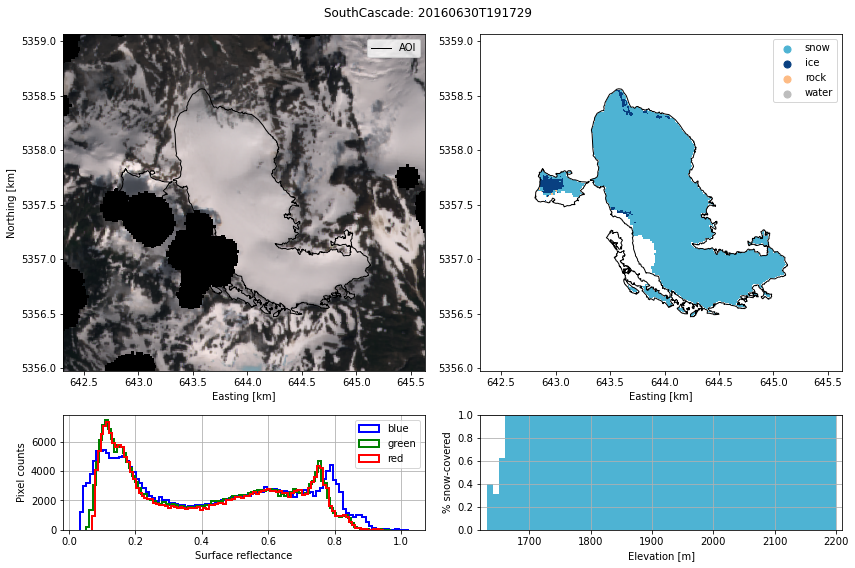

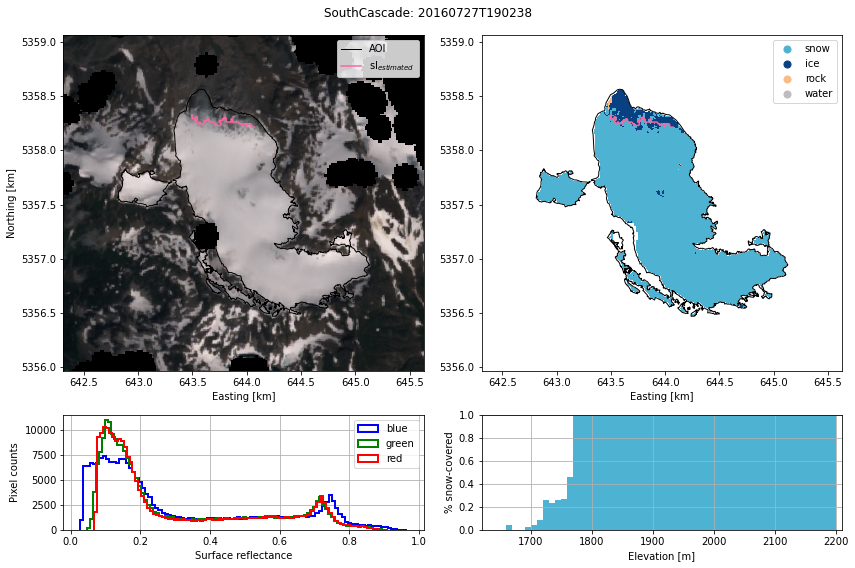

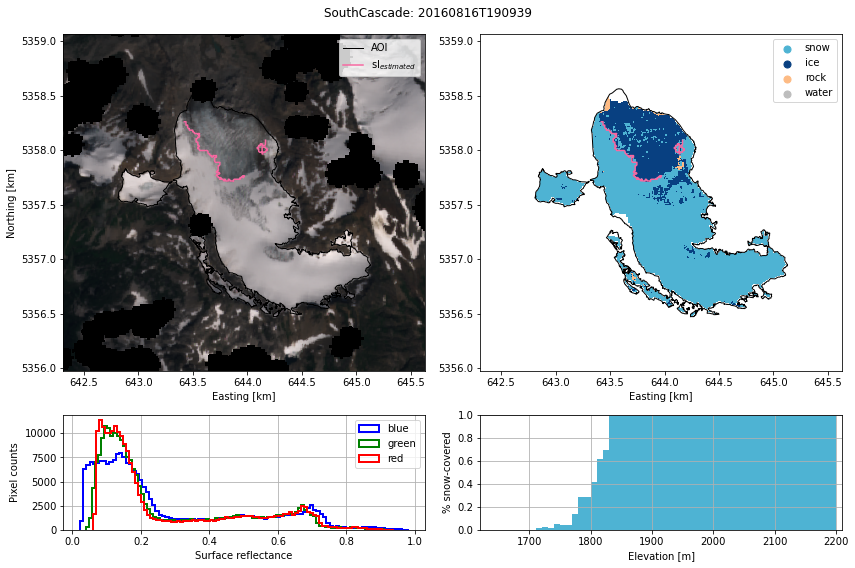

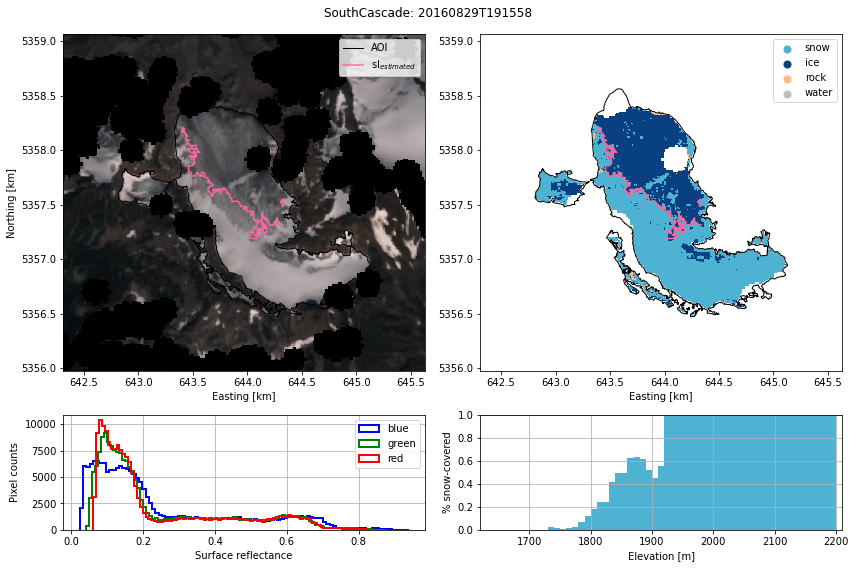

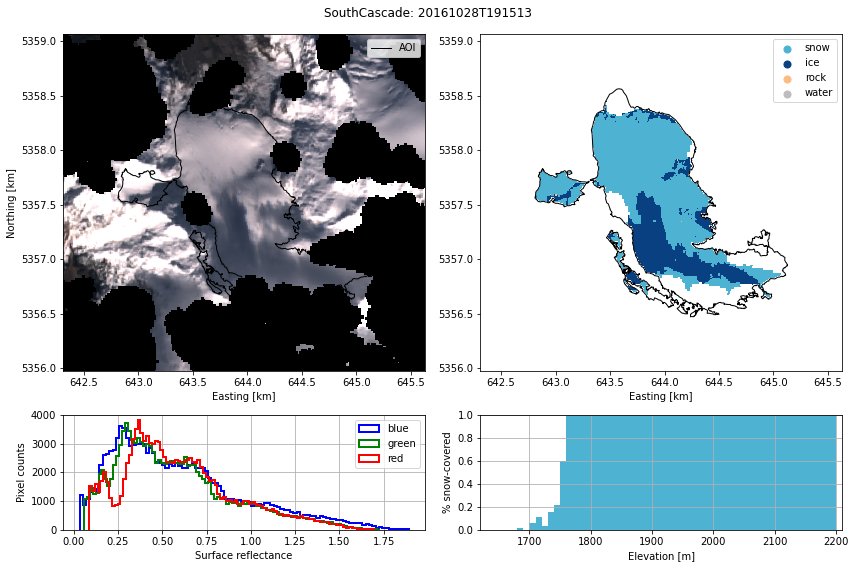

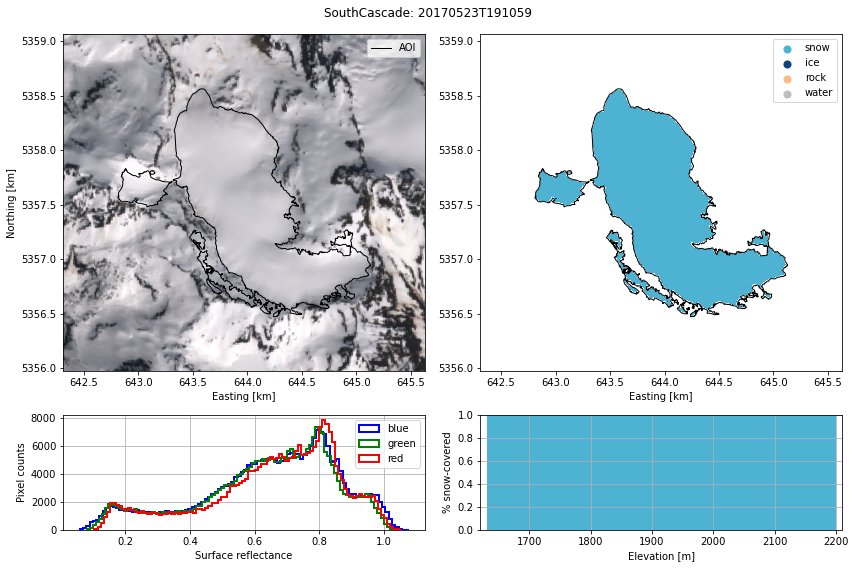

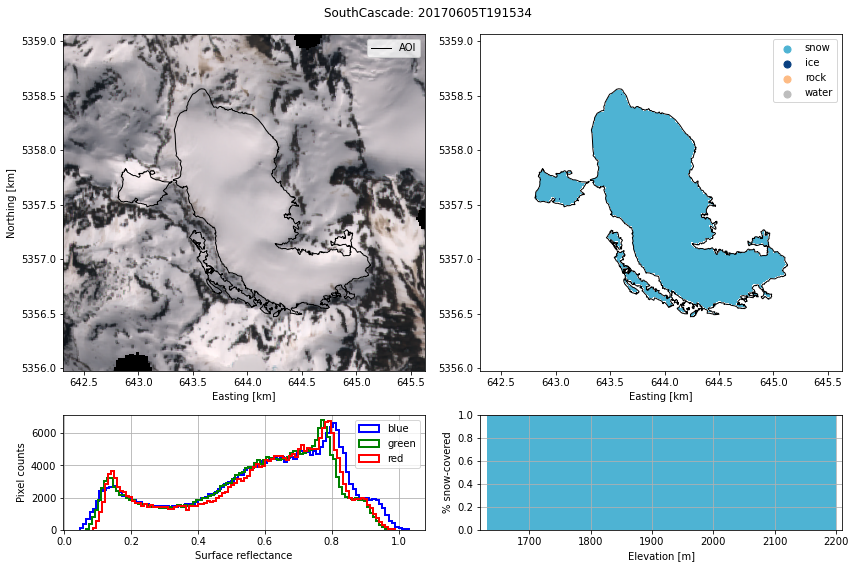

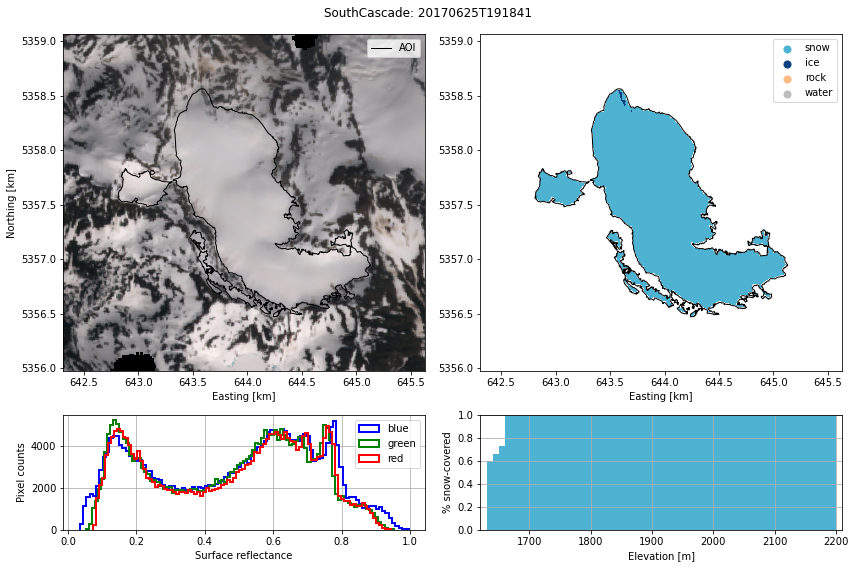

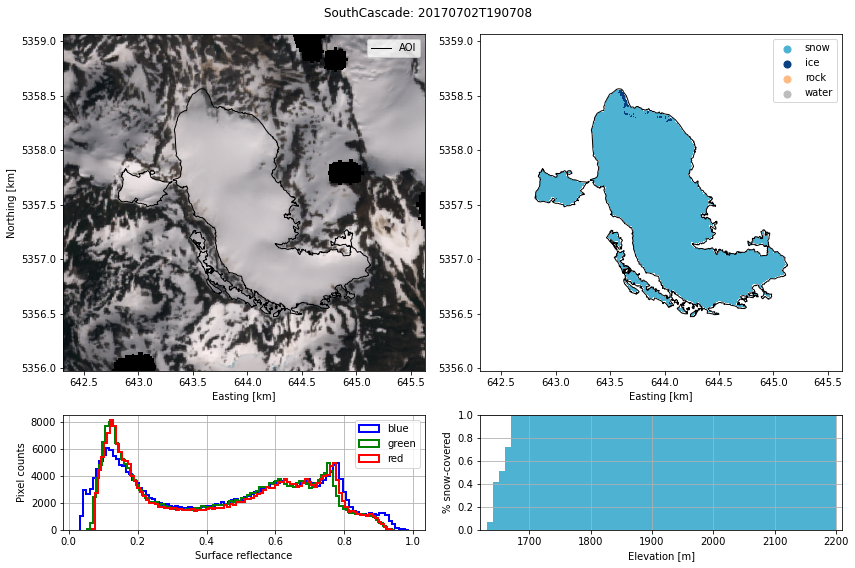

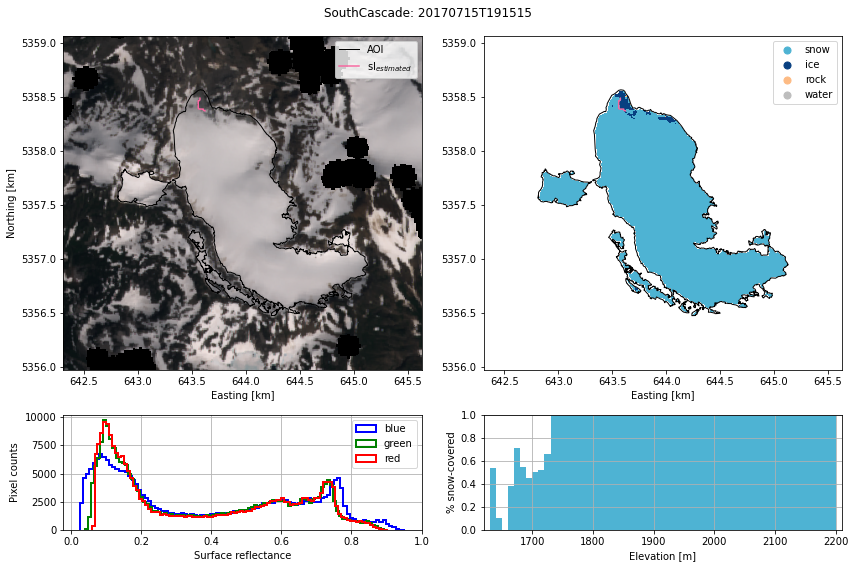

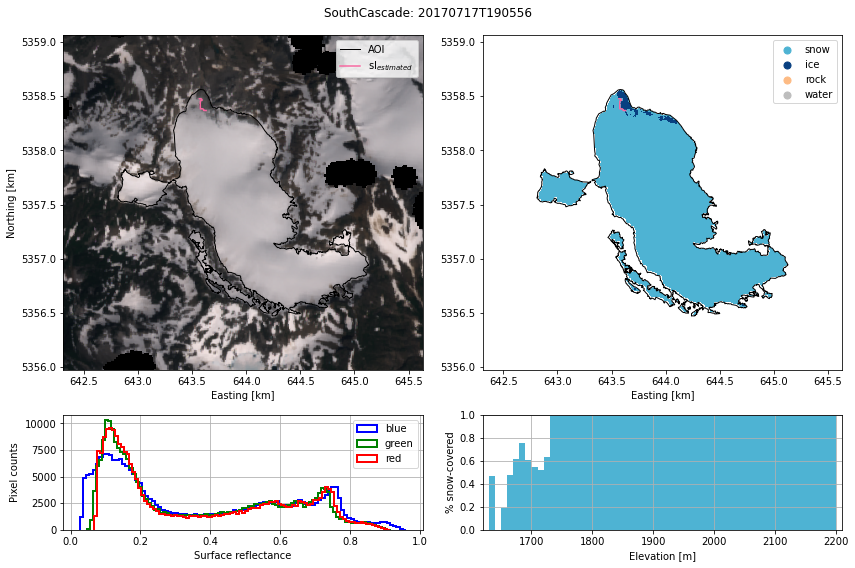

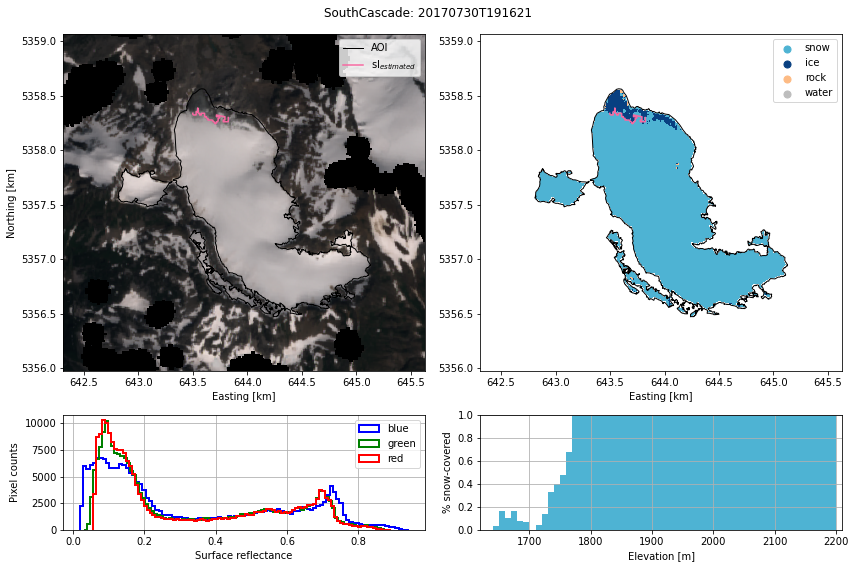

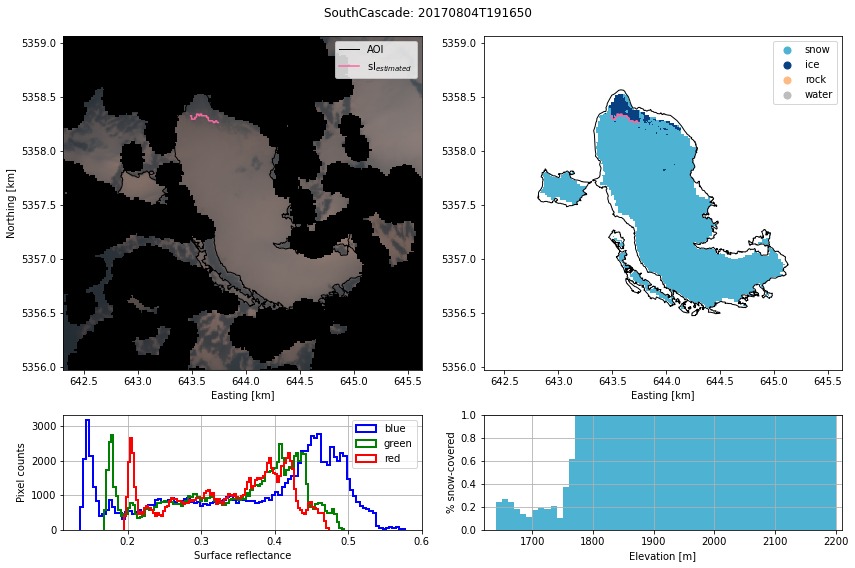

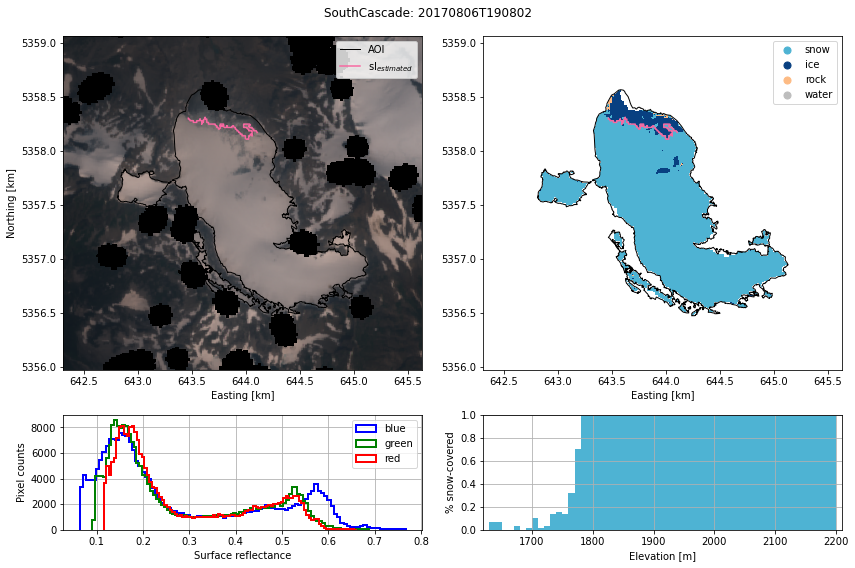

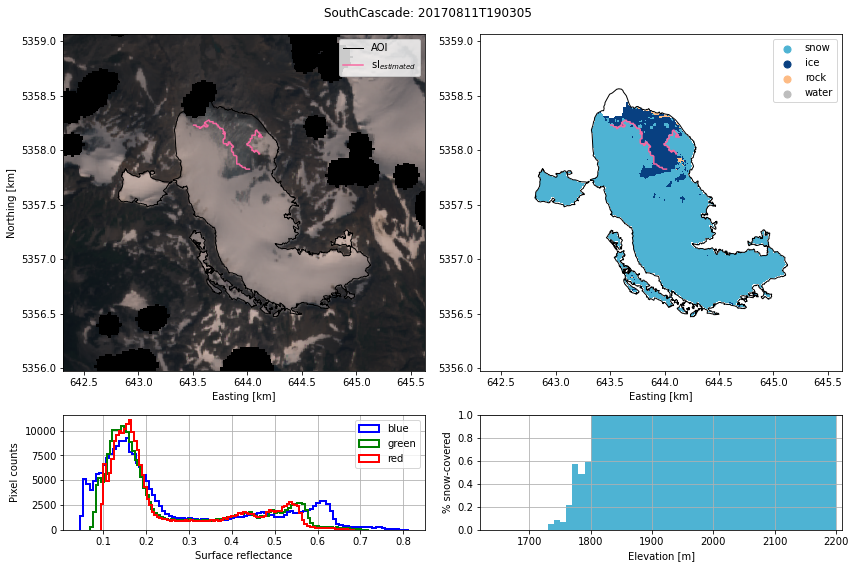

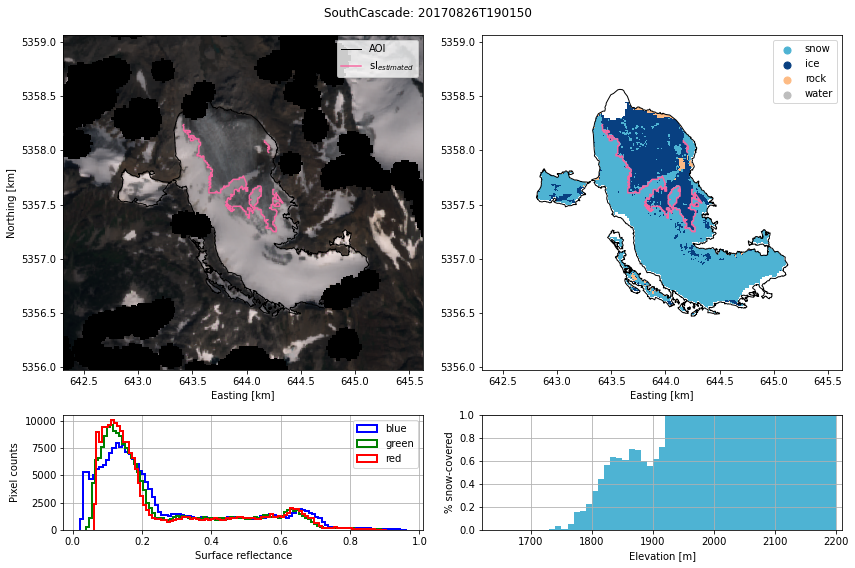

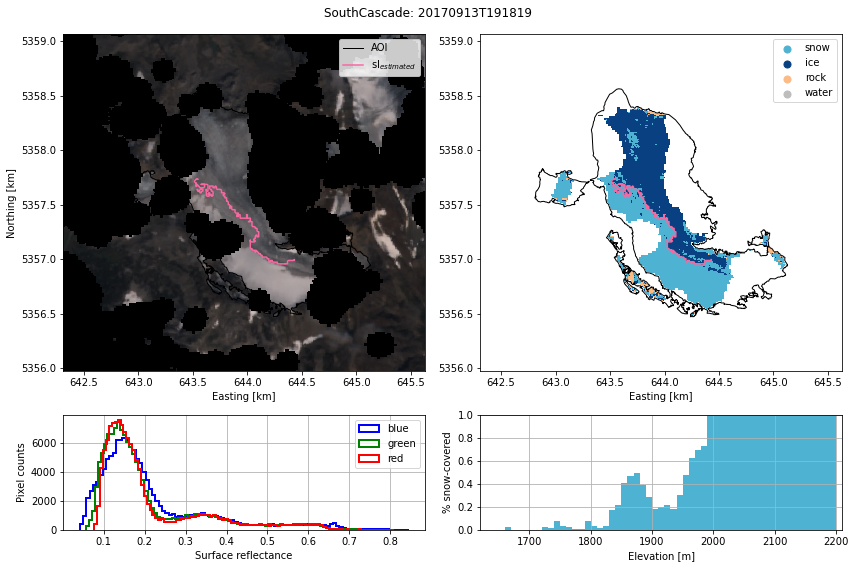

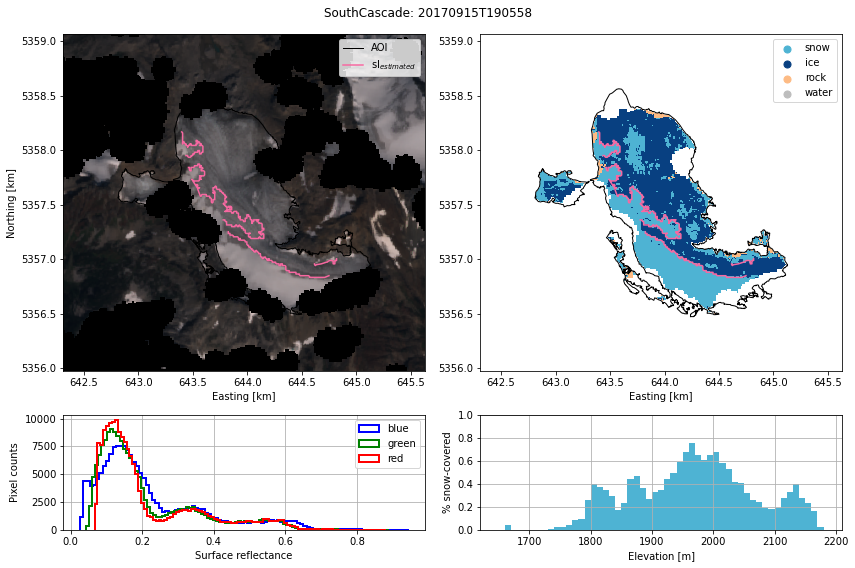

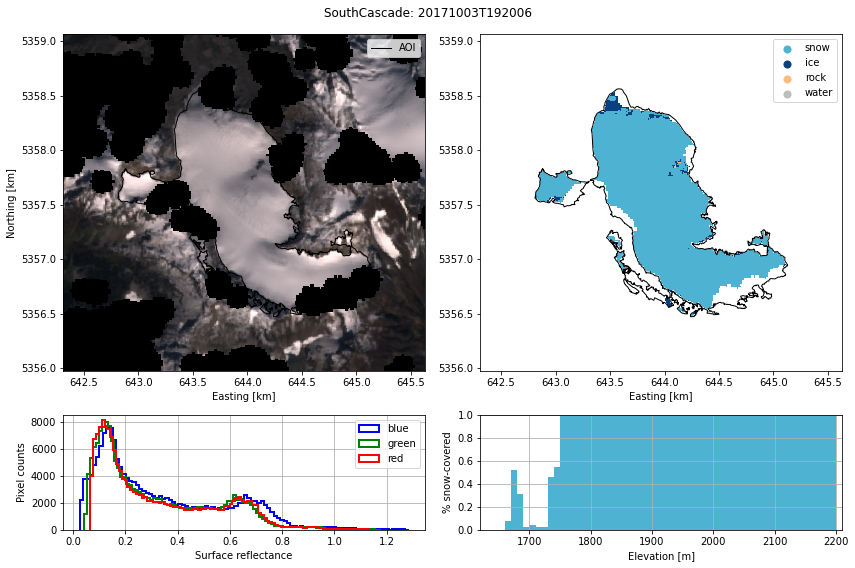

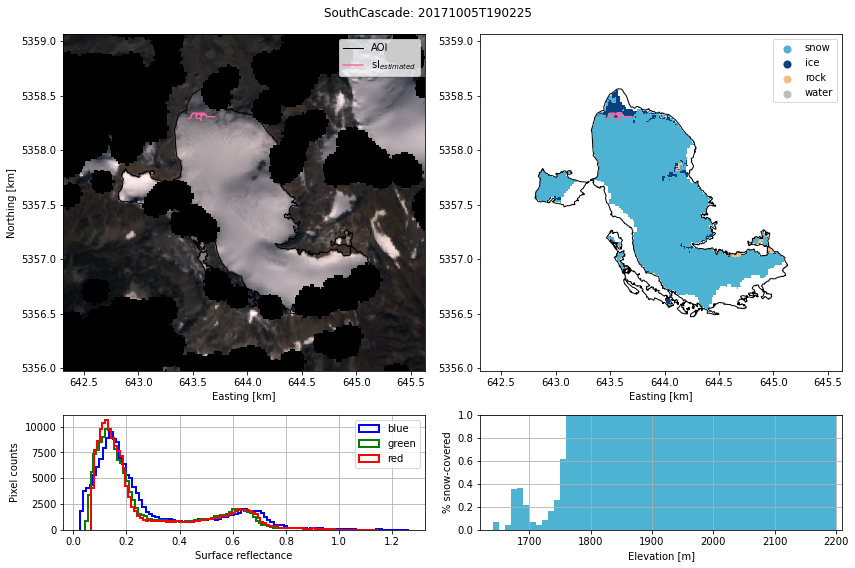

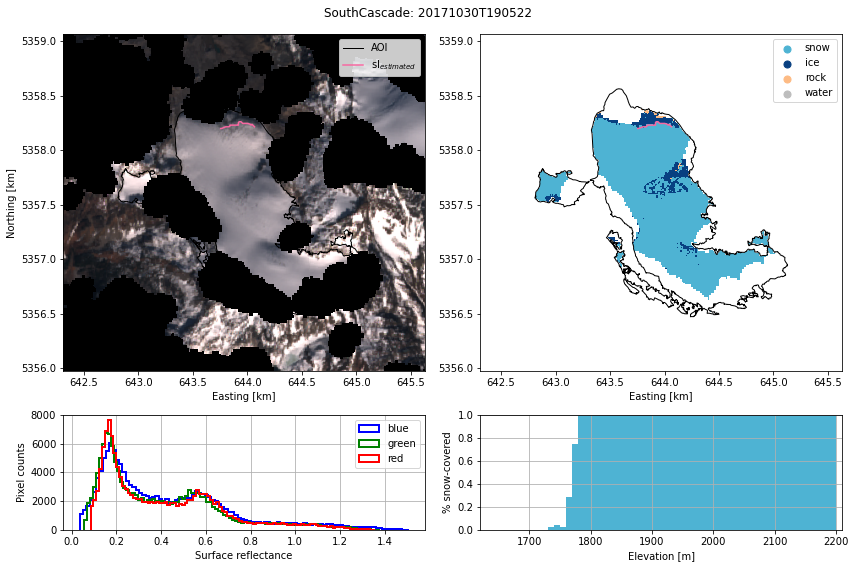

In [44]:
# -----TOA imagery
# load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/S2_TOA_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/S2_TOA_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))
    
# Query GEE for TOA imagery
dataset = 'Sentinel2_TOA'
ds_dict = dataset_dict[dataset]
bands = [band for band in ds_dict['bands'] if 'QA' not in band]
S2_TOA_list = query_GEE_for_Sentinel2(dataset, site_name, AOI, date_start, date_end, month_start, month_end, cloud_cover_max, ds_dict)
print(' ')

# Initialize snowlines data frame
snowlines_df = pd.DataFrame(columns=['study_site', 'datetime', 'snowlines_coords', 'snowlines_elevs', 'snowlines_elevs_median'])
    
# loop through list of images
for i in range(0, S2_TOA_list.size().getInfo()):
    
    # select image by index
    im = ee.Image(ee.List(S2_TOA_list).get(i))
    # get image time
    im_date = im.date().format(None, 'GMT').getInfo()
    print(im_date)

    # convert image to xarray.Dataset
    im_xr = im.wx.to_xarray(scale=ds_dict['resolution_m'], crs='EPSG:4326')
    # reproject to UTM CRS
    im_xr_UTM = im_xr.rio.reproject('EPSG:'+epsg_UTM)
    # replace no data values with NaN and account for image scalar
    for band in bands:
        im_xr_UTM[band] = xr.where(im_xr_UTM[band] != ds_dict['no_data_value'],
                                   im_xr_UTM[band] / ds_dict['im_scalar'], np.nan)   
        
    # add NDSI band
    im_xr_UTM['NDSI'] = ((im_xr_UTM[ds_dict['NDSI'][0]] - im_xr_UTM[ds_dict['NDSI'][1]]) 
                         / (im_xr_UTM[ds_dict['NDSI'][0]] + im_xr_UTM[ds_dict['NDSI'][1]]))
    
    # classify image
    im_classified_xr = classify_image(im_xr_UTM, clf, feature_cols, crop_to_AOI, AOI, ds_dict, dataset, site_name, im_classified_path, plot_results, figures_out_path)
    
    # delineate snowline(s)
    im_dt = str(im_classified_xr.time.data[0]).replace('-','').replace(':','')[0:15]    
    # check if snowline exists in directory already
    snowline_fn = im_dt + '_' + site_name + '_' + dataset + '_snowline.pkl'
    if os.path.exists(os.path.join(snowlines_path, snowline_fn)):
        print('snowline already exist in file, loading...')
        snowline_df = pickle.load(open(snowlines_path + snowline_fn,'rb'))
    else:
        # delineate snowline
        plot_results=True
        snowline_df = f.delineate_im_snowline(im_xr_UTM, im_classified_xr, site_name, AOI, DEM, ds_dict, 
                                               dataset, im_dt, snowlines_path, figures_out_path, plot_results)
    # save snowline to file
    snowline_df.to_pickle(snowlines_path + snowline_fn)
    print('snowline saved to file:' + snowlines_path + snowline_fn)
    # concatenate results to snowlines_df
    snowlines_df = pd.concat([snowlines_df, snowline_df])
    print(' ')

In [43]:
im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
im_classified_fn

'20160617T190258_SouthCascade_Sentinel2_TOA_classified.nc'